In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last"

pd.set_option('display.max_rows', 10000)

# EDA for EIA data

In [2]:
## Load in EIA data
eia_data = pd.read_feather('eia.feather')
## Convert `period` to datetime and `value` to numeric
eia_data['date_time'] = pd.to_datetime(eia_data['period'], format='%Y-%m-%dT%H')
eia_data['value'] = pd.to_numeric(eia_data['value'])
## Drop `period` column
eia_data.drop('period', axis=1, inplace=True)
## Print out info about data
eia_data.info(show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1760000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   respondent       1760000 non-null  object        
 1   respondent-name  1760000 non-null  object        
 2   fueltype         1760000 non-null  object        
 3   type-name        1760000 non-null  object        
 4   value            1760000 non-null  int64         
 5   value-units      1760000 non-null  object        
 6   date_time        1760000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 107.4+ MB


In [3]:
e = eia_data.head().copy()
e.to_feather('eia_head.feather')
e2 = eia_data[eia_data['type-name'].isin(['Solar', 'Hydro', 'Wind'])].head().copy()
e2.to_feather('eia_head2.feather')

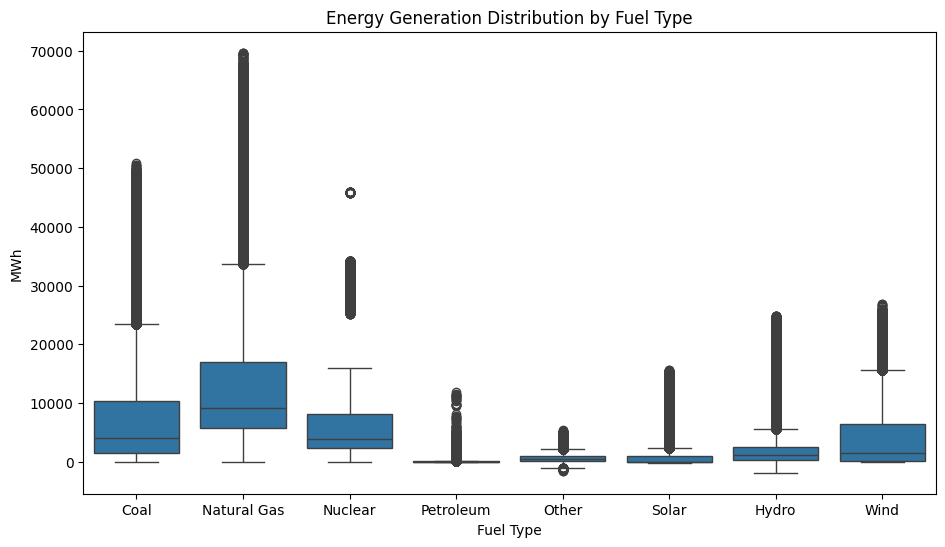

In [4]:
## Plot MWh Distribution by Fuel Type
fuel_dist_plt = plt.figure(figsize=(11, 6))
sns.boxplot(x='type-name', y='value', data=eia_data, legend=False, showfliers=True)
plt.title('Energy Generation Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# fuel_dist_plt.show()
plt.savefig('../images/MWh_Fuel_type.png')

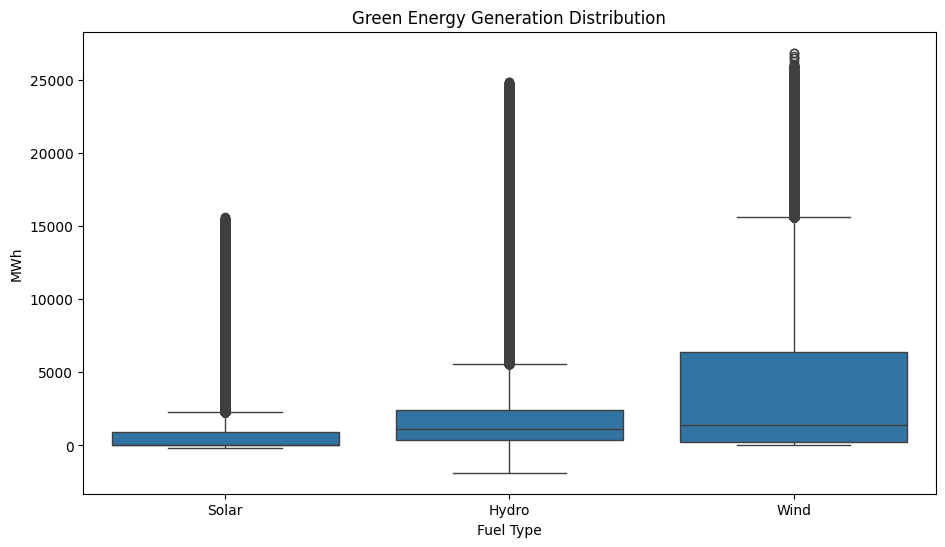

In [5]:
## Mostly curious about Solar, Hydro and Wind
green_data = eia_data[eia_data['type-name'].isin(['Solar', 'Hydro', 'Wind'])].copy()
green_dist_plt = plt.figure(figsize=(11, 6))
sns.boxplot(x='type-name', y='value', data=green_data, legend=False, showfliers=True)
plt.title('Green Energy Generation Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('MWh')
# green_dist_plt.show()
plt.savefig('../images/MWh_Green_type.png')

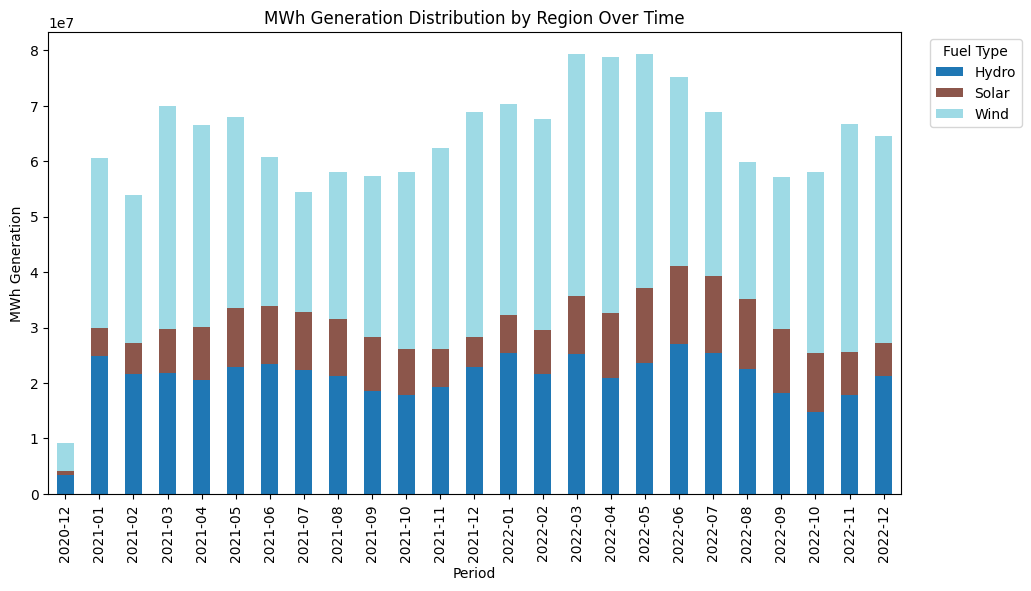

In [6]:
green_resampled = green_data.set_index('date_time').groupby(['respondent-name','type-name']).resample('MS')['value'].sum().reset_index()
green_resampled['date_time'] = green_resampled['date_time'].dt.strftime('%Y-%m')
green_resampled.head()

# Grouping and pivoting the data
grouped_data = green_resampled.groupby(['date_time', 'type-name',]).value.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(11, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Generation Distribution by Region Over Time')
plt.xlabel('Period')
plt.ylabel('MWh Generation')
plt.xticks(rotation=90)
plt.legend(title='Fuel Type',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/MWh_Green_type_time.png')

In [7]:
green_data.head()
green_pivot = green_data.pivot_table(index=['date_time','respondent-name'], columns='type-name', values='value').reset_index().fillna(0)
green_pivot['date_time'] = green_pivot['date_time'].dt.strftime('%Y-%m')

In [8]:
green_pivot.head()

type-name,date_time,respondent-name,Hydro,Solar,Wind
0,2020-12,California,950.0,3532.0,111.0
1,2020-12,Carolinas,32.0,3330.0,0.0
2,2020-12,Central,995.0,104.0,15465.0
3,2020-12,Florida,22.0,2787.0,0.0
4,2020-12,Mid-Atlantic,1731.0,1460.0,4926.0


# EDA for Demand Data

In [9]:
demand = pd.read_feather('demand.feather')
## Ensure column data types are as intended
## adjust sales-units from million kilowatthours to megawatthours
demand['sales'] = pd.to_numeric(demand['sales'])
demand['demand_mwh'] = demand['sales'] *100
demand['date_time'] = pd.to_datetime(demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
## Drop `period` column
demand.drop('period', axis=1, inplace=True)

demand.head()

,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region,demand_mwh,date_time
0,KY,Kentucky,COM,commercial,318852,12.04,190.02917,1578.19245,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Central,157819.245,2022-12
1,PA,Pennsylvania,ALL,all sectors,6258421,13.23,1717.34932,12976.52290,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Mid-Atlantic,1297652.290,2022-12
2,OR,Oregon,TRA,transportation,2,10.51,.21752,2.07022,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,207.022,2022-12
3,OR,Oregon,RES,residential,1836406,11.13,261.27007,2347.38685,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,234738.685,2022-12
4,OR,Oregon,OTH,other,None,None,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,NaN,2022-12


In [10]:
demand.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stateid           10000 non-null  object 
 1   stateDescription  10000 non-null  object 
 2   sectorid          10000 non-null  object 
 3   sectorName        10000 non-null  object 
 4   customers         8335 non-null   object 
 5   price             8335 non-null   object 
 6   revenue           8335 non-null   object 
 7   sales             8335 non-null   float64
 8   customers-units   10000 non-null  object 
 9   price-units       10000 non-null  object 
 10  revenue-units     10000 non-null  object 
 11  sales-units       10000 non-null  object 
 12  eia_region        9610 non-null   object 
 13  demand_mwh        8335 non-null   float64
 14  date_time         10000 non-null  object 
dtypes: float64(2), object(13)
memory usage: 1.2+ MB


In [11]:
## Checkout null values and drop them
demand = demand[demand.notnull().any(axis=1)]

In [12]:
demand.sectorName.unique()

array(['commercial', 'all sectors', 'transportation', 'residential',
       'other', 'industrial'], dtype=object)

/var/folders/s9/9q8cs9l92wd15gsnz7n8f0x40000gn/T/ipykernel_84083/3055808881.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  all_demand_plt.show()


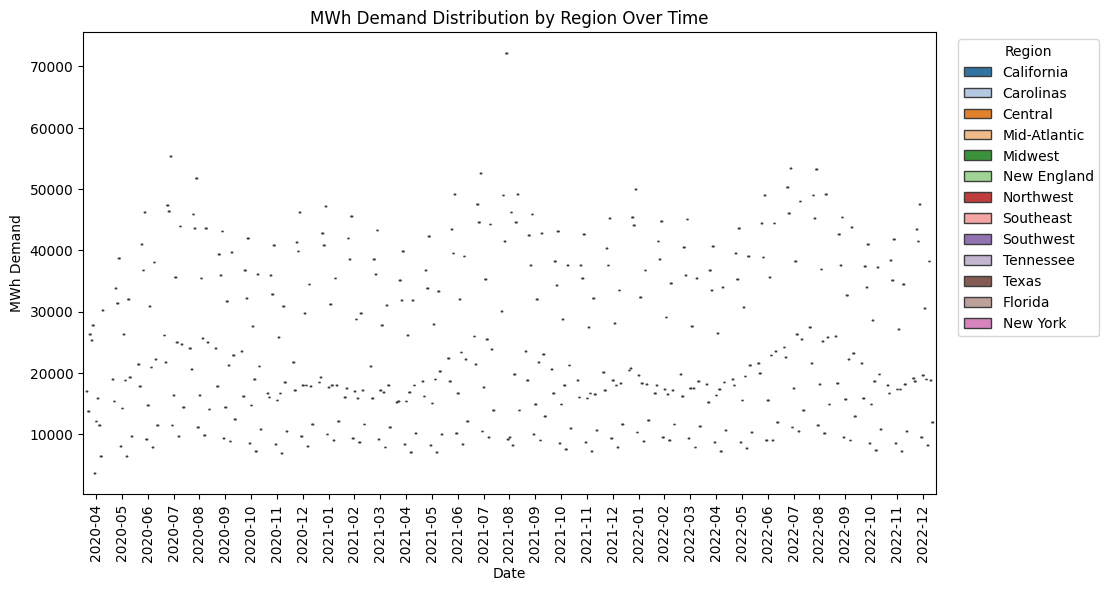

In [13]:
all_demand = demand[demand['sectorName'] == 'all sectors'].copy()
# all_demand['period'] = pd.to_datetime(all_demand['period'], format='%Y-%m').dt.strftime('%Y-%m')
all_demand_plt = plt.figure(figsize=(11, 6))
sns.boxplot(x='date_time', y='sales', data=all_demand.groupby(['date_time','eia_region']).sales.sum().reset_index(), palette='tab20', hue='eia_region')
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Date')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.2, 1), loc='upper right')
all_demand_plt.show()
plt.savefig('../images/MWh_demand.png')

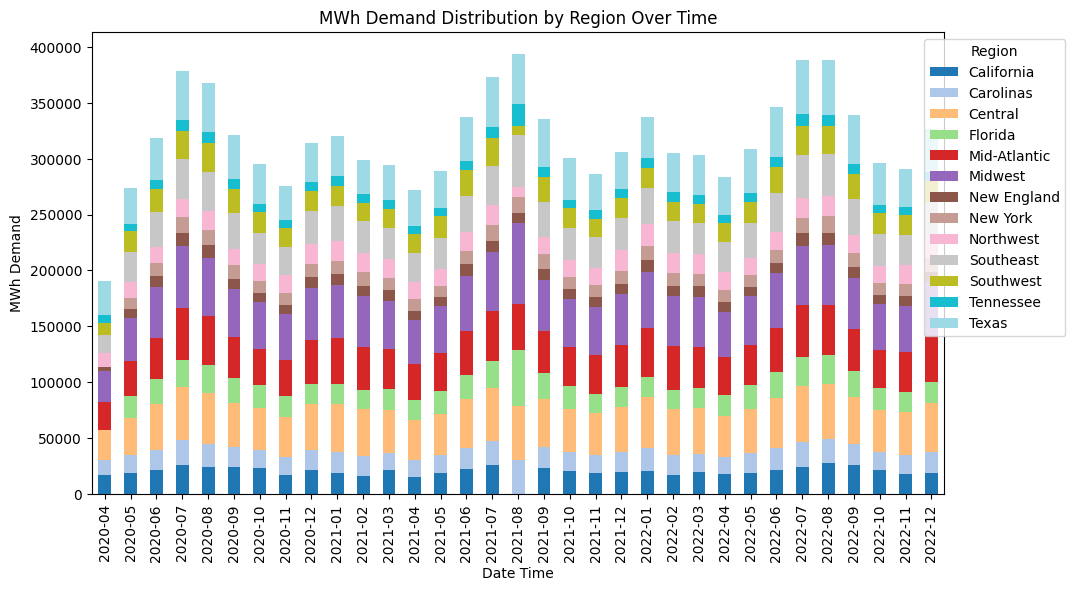

In [14]:
# Grouping and pivoting the data
grouped_data = all_demand.groupby(['date_time', 'eia_region']).sales.sum().unstack().fillna(0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(11, 6))
grouped_data.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

# Customizing the plot
plt.title('MWh Demand Distribution by Region Over Time')
plt.xlabel('Date Time')
plt.ylabel('MWh Demand')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.15, 1), loc='upper right')

# Display the plot
plt.show()

# Save the plot
fig.savefig('../images/MWh_demand2.png')

In [15]:
all_demand.head()

,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,eia_region,demand_mwh,date_time
1,PA,Pennsylvania,ALL,all sectors,6258421,13.23,1717.34932,12976.52290,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Mid-Atlantic,1297652.290,2022-12
7,OR,Oregon,ALL,all sectors,2108598,9.71,518.77292,5342.36336,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Northwest,534236.336,2022-12
13,OK,Oklahoma,ALL,all sectors,2170997,9.52,540.34516,5674.86691,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Central,567486.691,2022-12
20,MS,Mississippi,ALL,all sectors,1591888,10.41,396.22799,3806.35278,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Southeast,380635.278,2022-12
26,MN,Minnesota,ALL,all sectors,2856524,11.49,676.69187,5890.83985,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,Central,589083.985,2022-12


In [16]:
all_demand['date_time'] = pd.to_datetime(all_demand['date_time'], format='%Y-%m')
region_demand = all_demand.set_index('date_time').groupby(['eia_region']).resample('MS')['demand_mwh'].sum().reset_index()

In [17]:
region_demand['date_time'] = region_demand['date_time'].dt.strftime('%Y-%m')
region_demand.head()

,eia_region,date_time,demand_mwh
0,California,2020-04,1696348.016
1,California,2020-05,1895669.382
2,California,2020-06,2145987.126
3,California,2020-07,2609831.993
4,California,2020-08,2400190.557


# EDA for Wind, Temperature, Precipitation & Irradiance Data

## Wind, Precipitation & Temperature

In [18]:
weather = pd.read_feather('weather.feather')
## Ensure column data types are as intended
weather.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 24123 entries, 0 to 730
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     0 non-null      float64       
 1   tavg      24123 non-null  float64       
 2   tmin      24123 non-null  float64       
 3   tmax      24123 non-null  float64       
 4   prcp      24123 non-null  float64       
 5   snow      14561 non-null  float64       
 6   wdir      24122 non-null  float64       
 7   wspd      24123 non-null  float64       
 8   wpgt      0 non-null      float64       
 9   pres      24123 non-null  float64       
 10  tsun      703 non-null    float64       
 11  coord     24123 non-null  object        
 12  location  24123 non-null  object        
 13  time      24123 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(11), object(2)
memory usage: 2.8+ MB


In [19]:
## Reduce to columns of interest
wind_temp = weather[['time', 'location', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd','prcp']].copy()

In [20]:
wind_temp.head()

,time,location,tavg,tmin,tmax,wdir,wspd,prcp
0,2022-01-01,California,5.3,0.6,11.7,64.0,4.7,0.0
1,2022-01-02,California,6.2,0.6,13.9,53.0,3.6,0.0
2,2022-01-03,California,6.8,0.6,13.9,18.0,3.2,0.0
3,2022-01-04,California,8.0,3.3,15.0,41.0,4.0,0.0
4,2022-01-05,California,9.9,6.1,14.4,334.0,5.4,0.0


In [21]:
region_climate = wind_temp.groupby(['time','location']).agg({'tavg':'mean','wspd':'mean','prcp':'sum'}).reset_index()
region_climate.head()

,time,location,tavg,wspd,prcp
0,2022-01-01,California,8.300000,3.150000,0.0
1,2022-01-01,Carolinas,21.133333,17.766667,9.5
2,2022-01-01,Central,-10.766667,23.566667,19.1
3,2022-01-01,Florida,23.533333,11.233333,0.0
4,2022-01-01,Mid-Atlantic,13.366667,8.200000,36.1


In [22]:
wind_monthly = region_climate.set_index('time').groupby(['location']).resample('MS')[['tavg','wspd','prcp']].mean().reset_index()
wind_monthly.head()

,location,time,tavg,wspd,prcp
0,California,2022-01-01,11.777419,2.519355,0.338710
1,California,2022-02-01,13.016071,6.232143,0.210714
2,California,2022-03-01,15.753226,8.595161,1.441935
3,California,2022-04-01,17.558333,10.820000,0.350000
4,California,2022-05-01,19.764516,10.338710,0.000000


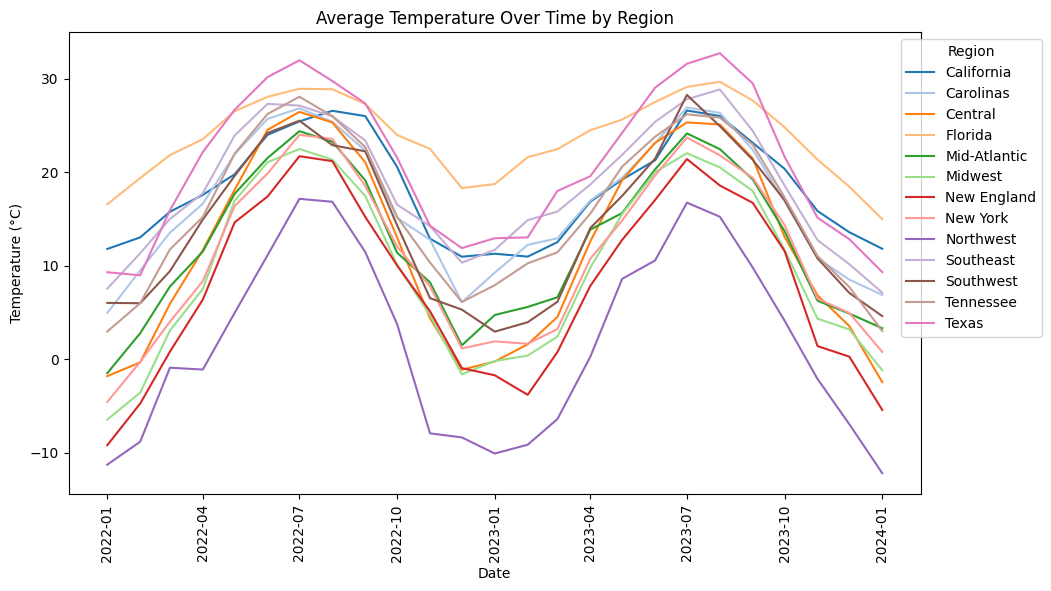

In [23]:
plt.figure(figsize=(11, 6))
sns.lineplot(x='time', y='tavg', data=wind_monthly, hue='location', palette='tab20')
plt.title('Average Temperature Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=90)
plt.legend(title='Region',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/avg_temp.png')
plt.show()

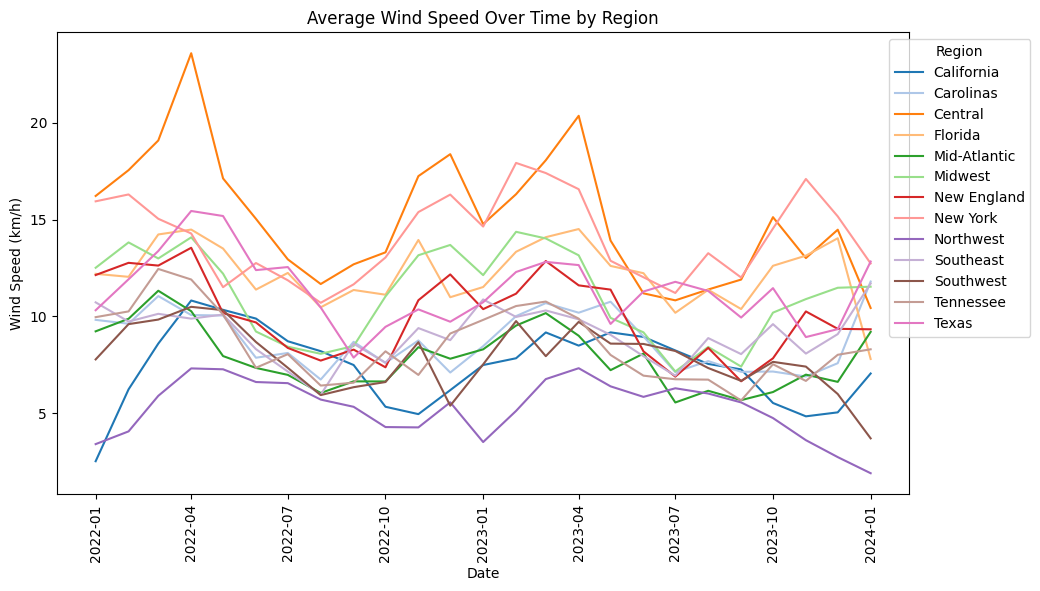

In [24]:
plt.figure(figsize=(11, 6))
sns.lineplot(x='time', y='wspd', data=wind_monthly, hue='location', palette='tab20')
plt.title('Average Wind Speed Over Time by Region')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Wind Speed (km/h)')
plt.legend(title='Region',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/avg_wind.png')
plt.show()

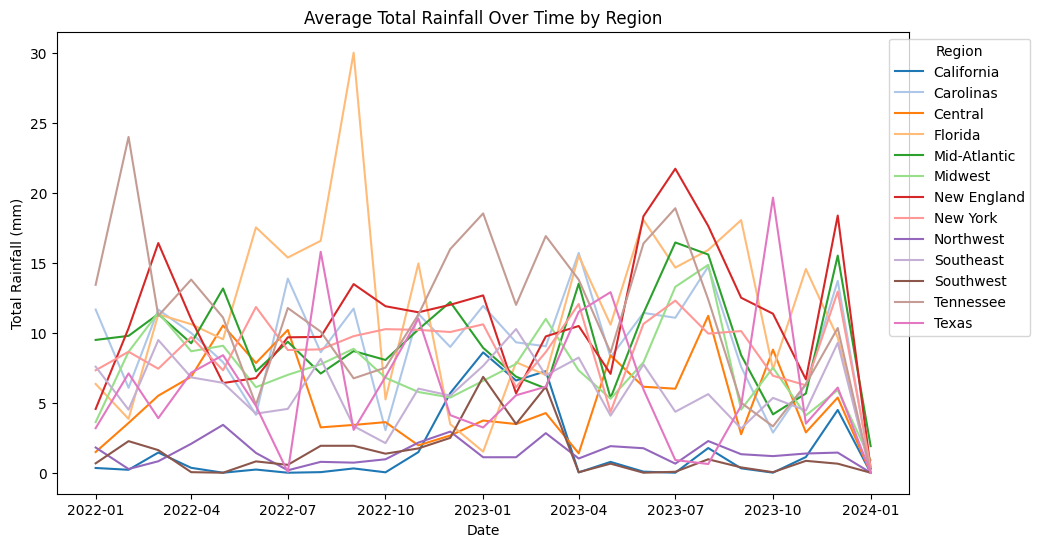

In [25]:
plt.figure(figsize=(11, 6))
sns.lineplot(x='time', y='prcp', data=wind_monthly, hue='location', palette='tab20')
plt.title('Average Total Rainfall Over Time by Region')
plt.xlabel('Date')
plt.ylabel('Total Rainfall (mm)')
plt.legend(title='Region',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/avg_rain.png')
plt.show()

In [26]:
wind_monthly['time'] = wind_monthly['time'].dt.strftime('%Y-%m')
wind_monthly.head()

,location,time,tavg,wspd,prcp
0,California,2022-01,11.777419,2.519355,0.338710
1,California,2022-02,13.016071,6.232143,0.210714
2,California,2022-03,15.753226,8.595161,1.441935
3,California,2022-04,17.558333,10.820000,0.350000
4,California,2022-05,19.764516,10.338710,0.000000


## Irradiance

In [27]:
irradiance = pd.read_feather('irradiance.feather')

In [28]:
irradiance.info(show_counts=True)
irradiance.head(25)

<class 'pandas.core.frame.DataFrame'>
Index: 911040 entries, 0 to 8759
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Year                911040 non-null  int64  
 1   Month               911040 non-null  int64  
 2   Day                 911040 non-null  int64  
 3   Hour                911040 non-null  int64  
 4   Minute              911040 non-null  int64  
 5   GHI                 911040 non-null  int64  
 6   DHI                 911040 non-null  int64  
 7   DNI                 911040 non-null  int64  
 8   Solar Zenith Angle  911040 non-null  float64
 9   eia_region          911040 non-null  object 
 10  coord               911040 non-null  object 
dtypes: float64(1), int64(8), object(2)
memory usage: 83.4+ MB


,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Solar Zenith Angle,eia_region,coord
0,2020,1,1,0,30,23,13,325,88.19,California,"40.0,-120.0"
1,2020,1,1,1,30,0,0,0,98.64,California,"40.0,-120.0"
2,2020,1,1,2,30,0,0,0,109.51,California,"40.0,-120.0"
3,2020,1,1,3,30,0,0,0,120.82,California,"40.0,-120.0"
4,2020,1,1,4,30,0,0,0,132.29,California,"40.0,-120.0"
5,2020,1,1,5,30,0,0,0,143.59,California,"40.0,-120.0"
6,2020,1,1,6,30,0,0,0,154.02,California,"40.0,-120.0"
7,2020,1,1,7,30,0,0,0,161.63,California,"40.0,-120.0"
8,2020,1,1,8,30,0,0,0,162.12,California,"40.0,-120.0"
9,2020,1,1,9,30,0,0,0,155.04,California,"40.0,-120.0"


In [29]:
## Calculate Plane of Array Irradiance (https://pvpmc.sandia.gov/modeling-guide/1-weather-design-inputs/plane-of-array-poa-irradiance/)
irradiance['poa'] = irradiance.GHI + irradiance.DHI + irradiance.DNI

irradiance['month_year']  = pd.to_datetime(irradiance[['Year', 'Month']].assign(day=1))

irradiance_resampled = irradiance.set_index('month_year').groupby('eia_region').resample('MS')['poa'].sum().reset_index()

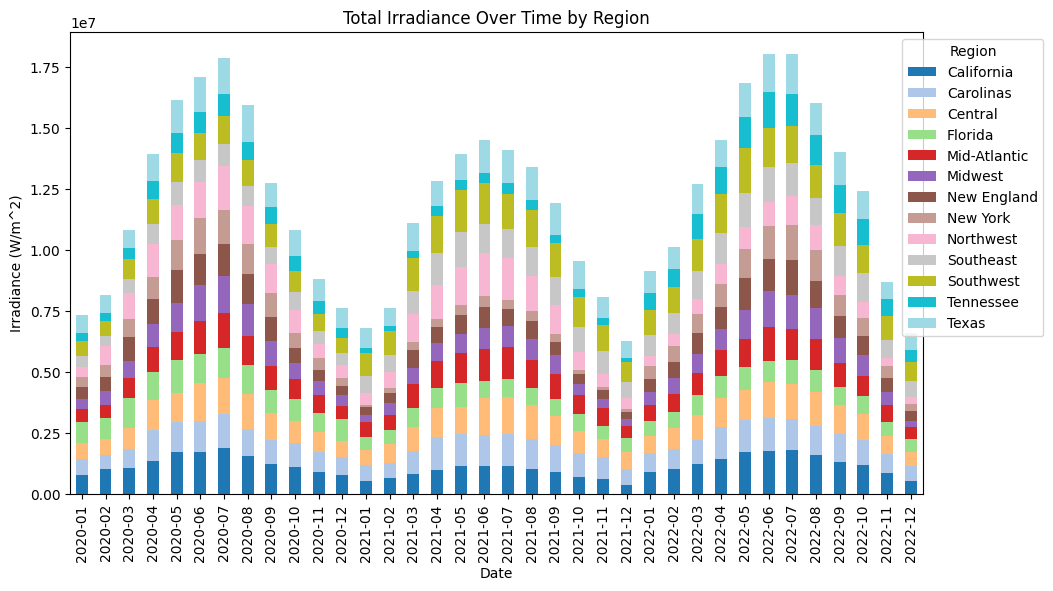

In [30]:
# irradiance_resampled.head()
pivot = irradiance_resampled.pivot(index='month_year', columns='eia_region', values='poa').fillna(0)
pivot.index = pivot.index.strftime('%Y-%m')
# plt.figure(figsize=(10, 6))
# sns.barplot(x='month_year', y='poa', data=irradiance_resampled, hue='eia_region', palette='tab20')
pivot.plot(kind='bar', stacked=True, colormap='tab20', figsize=(11, 6))
plt.title('Total Irradiance Over Time by Region')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Irradiance (W/m^2)')
plt.legend(title='Region',bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('../images/irradiance.png')

In [31]:
irradiance_resampled['date_time'] = pd.to_datetime(irradiance_resampled['month_year'], format='%Y-%m').dt.strftime('%Y-%m')
irradiance_resampled.head()

,eia_region,month_year,poa,date_time
0,California,2020-01-01,765879,2020-01
1,California,2020-02-01,1012951,2020-02
2,California,2020-03-01,1051803,2020-03
3,California,2020-04-01,1332474,2020-04
4,California,2020-05-01,1725977,2020-05


# Combine the datasets

In [32]:
final_df = pd.merge(green_pivot, region_demand, left_on=['date_time', 'respondent-name'], right_on=['date_time', 'eia_region'], how='inner').drop(columns=['respondent-name'])
final_df = pd.merge(final_df, wind_monthly, left_on=['date_time', 'eia_region'], right_on=['time', 'location'], how='inner').drop(columns=['location', 'time'])
final_df = pd.merge(final_df, irradiance_resampled, on=['date_time', 'eia_region'], how='inner').drop(columns=['month_year'])
final_df['month_year'] = pd.to_datetime(final_df['date_time'], format='%Y-%m')

In [33]:
final_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113581 entries, 0 to 113580
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date_time   113581 non-null  object        
 1   Hydro       113581 non-null  float64       
 2   Solar       113581 non-null  float64       
 3   Wind        113581 non-null  float64       
 4   eia_region  113581 non-null  object        
 5   demand_mwh  113581 non-null  float64       
 6   tavg        113581 non-null  float64       
 7   wspd        113581 non-null  float64       
 8   prcp        113581 non-null  float64       
 9   poa         113581 non-null  int64         
 10  month_year  113581 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 9.5+ MB


In [34]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period: int) -> FunctionTransformer:
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period: int) -> FunctionTransformer:
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def create_sine_cosine_doy_feature(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    df['month'] = df[date_col].dt.month
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
    return df



In [35]:
final_df = create_sine_cosine_doy_feature(final_df, 'month_year')

In [36]:
final_df.head()

,date_time,Hydro,Solar,Wind,eia_region,demand_mwh,tavg,wspd,prcp,poa,month_year,month,month_sin,month_cos
0,2022-01,2766.0,1859.0,3334.0,California,2042244.347,11.777419,2.519355,0.338710,887638,2022-01-01,1,0.5,0.866025
1,2022-01,2322.0,31.0,0.0,Carolinas,2075169.565,4.939785,9.820430,11.667742,776742,2022-01-01,1,0.5,0.866025
2,2022-01,1304.0,0.0,17695.0,Central,4539319.095,-1.819355,16.219355,1.480645,713940,2022-01-01,1,0.5,0.866025
3,2022-01,33.0,8.0,0.0,Florida,1813852.253,16.555914,12.197849,6.345161,618925,2022-01-01,1,0.5,0.866025
4,2022-01,3044.0,17.0,3494.0,Mid-Atlantic,4413106.059,-1.503226,9.227957,9.493548,637646,2022-01-01,1,0.5,0.866025


In [37]:
f_head = final_df.head(10)
f_head.to_feather('final_head.feather')
final_df.to_feather('final.feather')

# PCA

In [38]:
scaler = StandardScaler()
## Remove dimensions that are not quantitative and not the label `demand_mwh`
pca_df = final_df[['Hydro','Solar','Wind','tavg','wspd','prcp','poa','month_sin', 'month_cos']].copy()
pca_df.head().to_feather('pca_head.feather')

In [39]:
scaled_data = scaler.fit_transform(pca_df)
scaled_data

array([[ 1.06487881e-01,  3.09447229e-01, -8.68151396e-02, ...,
        -3.57169225e-01,  7.15290024e-01,  1.23094752e+00],
       [-6.68569182e-04, -4.52746749e-01, -6.75608019e-01, ...,
        -6.80527543e-01,  7.15290024e-01,  1.23094752e+00],
       [-2.46356106e-01, -4.65672359e-01,  2.44937398e+00, ...,
        -8.63650010e-01,  7.15290024e-01,  1.23094752e+00],
       ...,
       [-4.86251401e-01, -3.04727678e-01, -2.98561589e-01, ...,
        -7.43367457e-01,  7.63596373e-03,  1.42028015e+00],
       [ 2.89908831e-01, -4.66506269e-01, -6.74371801e-01, ...,
        -1.44779499e+00,  7.63596373e-03,  1.42028015e+00],
       [-5.59861125e-01, -2.73456043e-01,  4.91381587e-01, ...,
        -8.79570660e-01,  7.63596373e-03,  1.42028015e+00]])

In [40]:
pca_n2 = PCA(n_components=2)
pca_n3 = PCA(n_components=3)

pc_2 = pca_n2.fit_transform(scaled_data)
pc_3 = pca_n3.fit_transform(scaled_data)

print(pca_n2.components_)
print(pca_n3.components_)

[[-0.14447792  0.17988505 -0.11808153  0.56191612 -0.13206518 -0.04575064
   0.55173099 -0.22656555 -0.49173281]
 [-0.49637846 -0.22907234  0.16963745  0.11557893  0.61754921  0.44729864
   0.04615076  0.24855073 -0.11682669]]
[[-0.14447792  0.17988505 -0.11808153  0.56191612 -0.13206518 -0.04575064
   0.55173099 -0.22656555 -0.49173281]
 [-0.49637846 -0.22907234  0.16963745  0.11557893  0.61754921  0.44729864
   0.04615076  0.24855073 -0.11682669]
 [ 0.25138736  0.23506774  0.54110896 -0.13159599  0.26606707 -0.46053807
   0.22870253  0.4249207  -0.23596968]]


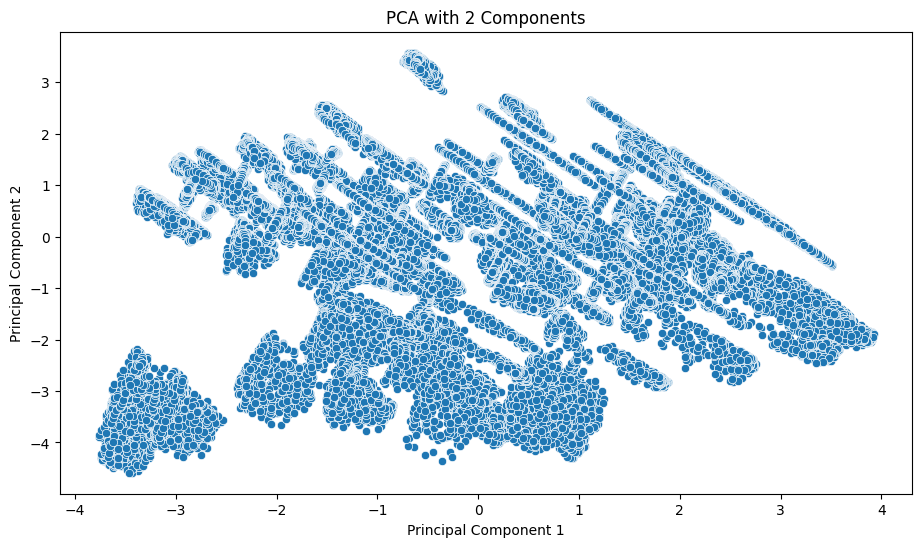

In [41]:
plt.figure(figsize=(11, 6))
sns.scatterplot(x=pc_2[:,0], y=pc_2[:,1])
plt.title('PCA with 2 Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.savefig('../images/pca_2.png')
plt.show()

In [42]:
pc2_scaled_fit = pca_n2.fit(scaled_data)
exp_var_n2 = pc2_scaled_fit.explained_variance_ratio_
exp_var_n2

array([0.29927026, 0.19274337])

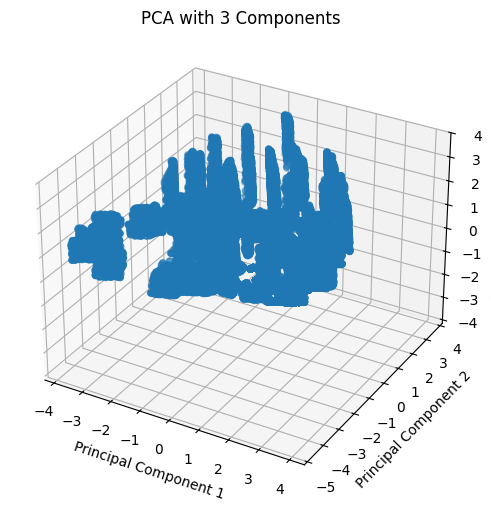

In [43]:
pc3_fig = plt.figure(figsize=(11, 6))
plt_axes = plt.axes(projection='3d')

plt_axes.scatter3D(pc_3[:,0], pc_3[:,1], pc_3[:,2])
plt_axes.set_xlabel('Principal Component 1')
plt_axes.set_ylabel('Principal Component 2')
plt_axes.set_zlabel('Principal Component 3')
plt_axes.set_title('PCA with 3 Components')


plt.savefig('../images/pca_3.png')
plt.show()

In [44]:
pc3_scaled_fit = pca_n3.fit(scaled_data)
exp_var_n3 = pc3_scaled_fit.explained_variance_ratio_
exp_var_n3

array([0.29927026, 0.19274337, 0.15979564])

[2.69345609 1.73470563 1.4381734 ]
6


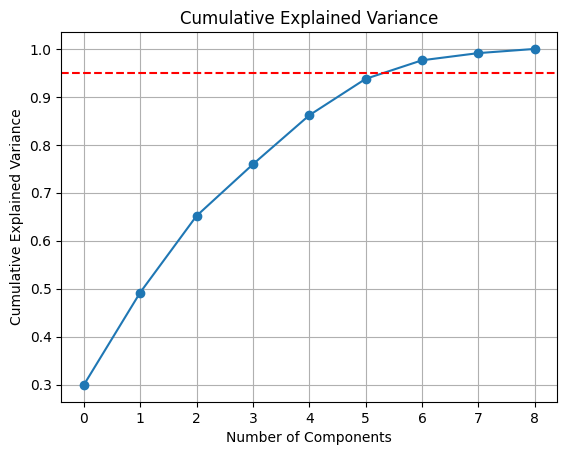

In [45]:
pca = PCA()
pca.fit(scaled_data)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
eigenvalues = pca.explained_variance_
print(eigenvalues[:3])
# Determine the number of components needed to retain at least 95% of the variance
num_components = np.argmax(cumulative_explained_variance >= 0.95) 

# Plot cumulative explained variance
fig, ax = plt.subplots()
ax.plot(cumulative_explained_variance, marker='o')
ax.axhline(y=0.95, color='r', linestyle='--')
ax.set_title('Cumulative Explained Variance')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.grid(True)

plt.savefig('../images/cumulative_variance.png')
print(num_components)

# # Display the plot and result in Streamlit
# st.pyplot(fig)
# st.write(f"Number of components needed to retain at least 95% of the variance: {num_components}")

# Clustering

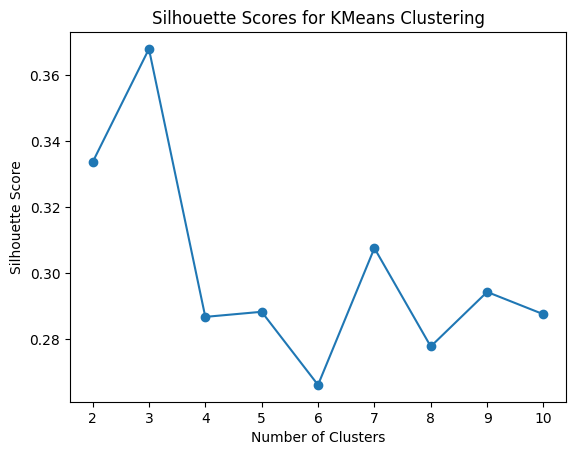

In [191]:
# pc_3

# k_values = range(2, 11)
# silhouette_scores = []
# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=0)
#     kmeans.fit(pc_3)
#     score = silhouette_score(pc_3, kmeans.labels_)
#     silhouette_scores.append(score)

# # Plot the silhouette scores
# plt.plot(k_values, silhouette_scores, marker='o')
# plt.title('Silhouette Scores for KMeans Clustering')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Silhouette Score')
# plt.savefig('../images/silhouette_scores.png')
# plt.show()




In [46]:
final_df['label'] = np.where(final_df['demand_mwh'] > 3.6e6, 'High', np.where(final_df['demand_mwh'] < 1.5e6, 'Low', 'Medium'))

In [47]:
labels = final_df['label']
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
numerical_labels = labels.map(label_mapping)



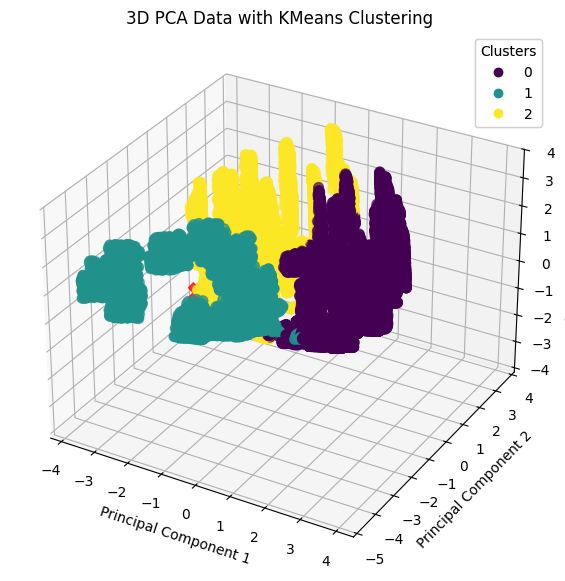

In [48]:

# # Choose three smart values of k based on Silhouette scores
# smart_k_values = sorted(k_values, key=lambda k: silhouette_scores[k-2], reverse=True)[:3]

# # Perform KMeans clustering with the chosen k values
# kmeans_models = [KMeans(n_clusters=k, random_state=42).fit(pc_3) for k in smart_k_values]

# Perform KMeans clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pc_3)
centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Plot the 3D data with KMeans centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
scatter = ax.scatter(pc_3[:, 0], pc_3[:, 1], pc_3[:, 2], c=cluster_labels, cmap='viridis', s=50)

# Plot the centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='red', s=200, alpha=0.75, marker='X')

# Add labels and title
ax.set_title('3D PCA Data with KMeans Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.savefig('../images/kmeans_3d.png')

In [60]:
pc_3

array([[-0.69670788, -2.12956658,  0.03612665],
       [-1.70101726,  0.25762482, -0.95563244],
       [-2.67302836,  1.06822314,  2.16839992],
       ...,
       [-1.33904851, -1.3051125 , -0.69569704],
       [-2.04859673,  0.15916468, -1.87916102],
       [-1.30465839, -0.13581896, -0.20885377]])

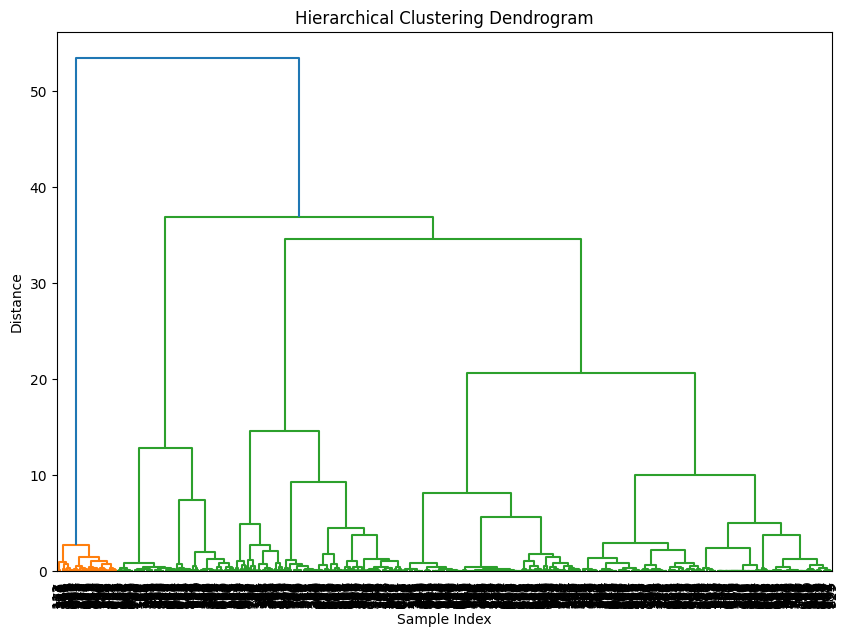

In [51]:
# Perform Hierarchical Clustering
linked = linkage(pc_3[:1000], method='ward')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 7))
dendrogram(linked, ax=ax,  leaf_rotation=90, leaf_font_size=10)
ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('Sample Index')
# ax.set_xtickslabels(rotation=90)
ax.set_ylabel('Distance')
plt.savefig('../images/dendrogram.png')

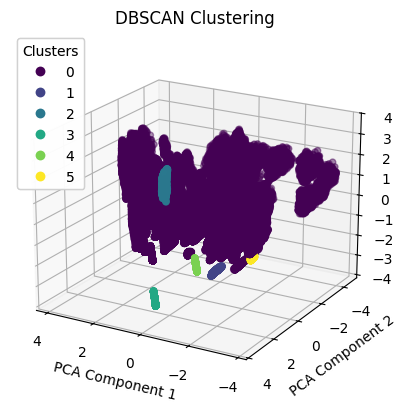

In [53]:
pc3_df = pd.DataFrame(pc_3, columns=['PC1', 'PC2', 'PC3'])
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(pc3_df)
# Check if pc_3 is a DataFrame
if isinstance(pc3_df, pd.DataFrame):
    # Check if the length of dbscan.labels_ matches the number of rows in pc_3
    if len(dbscan.labels_) == len(pc3_df):
        # Add cluster labels to the PCA data
        pc3_df['cluster'] = dbscan.labels_
    else:
        raise ValueError("Length of dbscan.labels_ does not match the number of rows in pc_3")
else:
    raise TypeError("pc_3 is not a pandas DataFrame")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pc3_df.iloc[:, 0], pc3_df.iloc[:, 1], pc3_df.iloc[:, 2], 
                     c=pc3_df['cluster'], cmap='viridis', s=20)  # Adjust point size with 's'
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
plt.title('DBSCAN Clustering')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.view_init(elev=20, azim=120)  # Adjust view angle
plt.savefig('../images/dbscan.png')
plt.show()

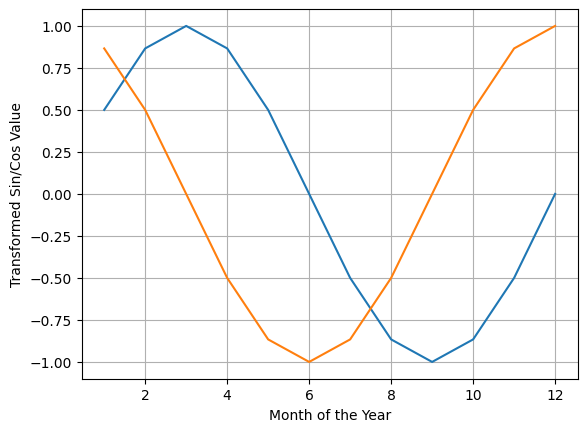

In [84]:
# test_df = pd.DataFrame({
#     'snapshot_date': pd.date_range(start='1/1/2023', end='12/31/2023')
# })

# test_df = create_sine_cosine_doy_feature(test_df, 'snapshot_date')

# plt.plot(test_df.month, test_df[['month_sin', 'month_cos']])
# plt.xlabel('Month of the Year')
# plt.ylabel('Transformed Sin/Cos Value')
# plt.grid()
# plt.savefig('../images/sin_cos.png')